In [1]:
import random
import torch as th
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import torchvision as tv
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [2]:
from stylegan_blocks import *

In [3]:
class StyleGenerator(nn.Module):
    def __init__(self, n_fc, dim_latent, dim_input, channels):
        super().__init__()
        assert len(channels) > 0
        
        self.latent_mapping = LatentMapping(n_fc, dim_latent)
        
        self.convBlocks  = nn.ModuleList([
            ConstStyleConvBlock(channels[0][1], dim_latent, dim_input),
        ] + [
            StyleConvBlock(chan[0], chan[1], dim_latent) for chan in channels[1:]
        ])
        
        self.convToRGBs = nn.ModuleList([
            nn.Conv2d(chan[1], 3, kernel_size=1) for chan in channels
        ])
        
    def forward(self, z, depth=0, noise=None, alpha=-1):
        
        w = self.latent_mapping(z)
        result = self.convBlocks[0](w, noise[0])
        
        if depth == 0:
            return self.convToRGBs[0](result)
            
        for blockIdx, convBlock in enumerate(self.convBlocks[1:], start=1):
            
            current_noise = noise[blockIdx]

            result_upsample = F.interpolate(result, scale_factor=2, mode='bilinear', align_corners=False)
            result = convBlock(result_upsample, w, current_noise)

            if blockIdx == depth:
                result_rgb = self.convToRGBs[blockIdx](result)

                if 0 <= alpha < 1:
                    prev_rgb = self.convToRGBs[blockIdx - 1](result_upsample)
                    result_rgb = alpha * result_rgb + (1 - alpha) * prev_rgb

                return result_rgb
            
            
class Discriminator(nn.Module):
    '''
    Main Module
    '''
    def __init__(self, channels):
        super().__init__()

        self.convFromRGBs = nn.ModuleList([
            nn.Conv2d(3, chan[0], kernel_size=1) for chan in channels
       ])
        self.convBlocks  = nn.ModuleList([
            ConvBlock(chan[0], chan[1], size_kernel1=3, padding1=1) for chan in channels[:-1]
        ] + [
            ConvBlock(channels[-1][0] + 1, channels[-1][1], size_kernel1=3, padding1=1, size_kernel2=4, padding2=0)
        ])
        self.fc = nn.Linear(channels[-1][1], 1)
        self.layersCount = len(self.convBlocks)
    
    def forward(self, image, depth=0, alpha=-1):
        
        result = self.convFromRGBs[self.layersCount - depth - 1](image)
        
        for blockIdx in range(self.layersCount - depth - 1, self.layersCount):

            if blockIdx == self.layersCount - 1:
                res_var = result.var(0, unbiased=False) + 1e-8 # Avoid zero
                res_std = torch.sqrt(res_var)
                mean_std = res_std.mean().expand(result.size(0), 1, 4, 4)
                result = torch.cat([result, mean_std], 1)
            
            result = self.convBlocks[blockIdx](result)
            
            if blockIdx != self.layersCount - 1:
                result = F.interpolate(result, scale_factor=0.5, mode='bilinear', align_corners=False)
                
                if blockIdx == self.layersCount - depth - 1 and 0 <= alpha < 1:
                    result_next = self.convFromRGBs[blockIdx + 1](image)
                    result_next = nn.functional.interpolate(result_next, scale_factor=0.5,
                                                           mode = 'bilinear', align_corners=False)
                
                    result = alpha * result + (1 - alpha) * result_next
        
        return self.fc(result.squeeze(2).squeeze(2))
    
def RecursiveInit(module):
    if '_modules' in module.__dict__:
        for module_name in module.__dict__['_modules']:
            RecursiveInit(module.__dict__['_modules'][module_name])
    else:
        module_name = module.__class__.__name__
        if 'Conv' in module_name:
            module.weight.data.normal_()
            module.bias.data.zero_()
            
        elif 'Linear' in module_name:
            module.weight.data.normal_()
            module.bias.data.zero_() 


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Dataset = tv.datasets.ImageFolder(root='data/celebA/')

In [5]:
def MakeLoader(dataset, batch_size, image_size):

    transform=transforms.Compose([
        transforms.Resize(int(image_size * 1.15), interpolation=3),
        #transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomCrop(image_size), 
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

    dataset.transform = transform
    loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=10)

    return loader

def ResetLR(optimizer, lr):
    for pam_group in optimizer.param_groups:
        mul = pam_group.get('mul', 1)
        pam_group['lr'] = lr * mul

In [6]:
resolutions =  {0: 4, 1: 8, 2: 16, 3: 32, 4: 64, 5: 128, 6: 256, 7: 512, 8: 1024} 

n_fc              = 4
dim_latent        = 512
dim_input         = 4

In [7]:
gen_channels = [
    (None, 512), # 0
    (512, 256), # 1
    (256, 128), # 2
    (128, 64), # 3
    (64, 64), # 4
    (64, 64), # 5
]

GEN = StyleGenerator(n_fc, dim_latent, dim_input, gen_channels).to(device)

if device.type == 'cuda':
    GEN = nn.DataParallel(GEN, [0, 1])

RecursiveInit(GEN)

In [8]:
dis_channels = [
    (8, 16), # 5
    (16, 32), # 4
    (32, 64), # 3
    (64, 128), # 2
    (128, 256), # 1
    (256, 256) # 0
]

DIS = Discriminator(dis_channels).to(device)

if device.type == 'cuda':
    DIS = nn.DataParallel(DIS, [0, 1])

RecursiveInit(DIS)

In [9]:
def MakeNoiseList(batch_size, depth):
    noises = []
    for d in range(depth + 1):
        noises.append(torch.randn(
            batch_size, gen_channels[d][1], resolutions[d], resolutions[d], device=device
        ))
    return noises

def set_grad_flag(module, flag):
    for p in module.parameters():
        p.requires_grad = flag

In [10]:
D_LR = 0.0005
G_LR = 0.0005

OptimizerBeta = 0.5


optimizerD = optim.Adam(DIS.parameters(), lr=D_LR, betas=(0.0, 0.99))
optimizerG = optim.Adam([
    {
        'params': GEN.module.convBlocks.parameters(),
        'lr'    : G_LR
    }, 
    {
        'params': GEN.module.convToRGBs.parameters(),
        'lr'    : G_LR
    },
    {
        'params': GEN.module.latent_mapping.parameters(),
        'lr'    : G_LR * 0.01,
        'mul'   : 0.01
    }
], lr=G_LR, betas=(0.0, 0.99))

Log = []
img_list = []

start_depth = 1 # Train from (8 * 8)
max_depth = 5 # (128 * 128)

#learning_rate = {4: 0.001, 5: 0.0015, 6: 0.002, 7: 0.003, 8: 0.003}
batch_sizes = {1: 32, 2: 16, 3: 8, 4: 4, 5: 4}
epochs = {1: 4, 2: 4, 3: 4, 4: 5, 5: 15}

VERBOSE = 500

iters = 0
fixed_z = th.randn(64, dim_latent, device=device)
fixed_noise = MakeNoiseList(batch_size=64, depth=max_depth)

for depth in range(start_depth, max_depth + 1):
    
    num_epochs = epochs.get(depth)
    batch_size = batch_sizes.get(depth)
    resolution  = resolutions.get(depth)
    batchLoader = MakeLoader(
        Dataset, 
        batch_size=batch_size, 
        image_size=resolution
    )

    batch_count = len(batchLoader)
    alphas = np.linspace(0.00001, 20, batch_count * num_epochs) / 10.0
    alphas[alphas < 0.0] = 0.0
    alphas[alphas > 1.0] = 1.0
    
    for epoch in range(num_epochs):

        for batch_idx, data in enumerate(batchLoader):
            alpha = alphas[batch_idx + epoch * batch_count]
            
            real_batch = data[0].to(device)
            
            if True:
                DIS.zero_grad()

                set_grad_flag(DIS, True)
                set_grad_flag(GEN, False)

                real_batch = data[0].to(device)

                real_batch.requires_grad = True
                real_output = DIS(real_batch, depth, alpha).view(-1)

                real_predict = F.softplus(-real_output).mean()
                real_predict.backward(retain_graph=True)

                grad_real = th.autograd.grad(outputs=real_predict.sum(), inputs=real_batch, create_graph=True)[0]
                grad_penalty_real = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
                grad_penalty_real = 5.0 * grad_penalty_real
                grad_penalty_real.backward()

                z = th.randn(batch_size, dim_latent, device=device)
                noise = MakeNoiseList(batch_size=batch_size, depth=depth)
                fake_batch = GEN(z=z, depth=depth, noise=noise, alpha=alpha)

                fake_output = DIS(fake_batch.detach(), depth, alpha).view(-1)
                fake_predict = F.softplus(fake_output).mean()
                fake_predict.backward()

                optimizerD.step()

                Loss_D_real = real_predict.item()
                Loss_D_fake = fake_predict.item()


                GEN.zero_grad()

                set_grad_flag(DIS, False)
                set_grad_flag(GEN, True)

                z = th.randn(batch_size, dim_latent, device=device)
                noise = MakeNoiseList(batch_size=batch_size, depth=depth)
                fake_batch = GEN(z=z, depth=depth, noise=noise, alpha=alpha)
                fake_output = DIS(fake_batch, depth, alpha).view(-1)

                fake_predict = nn.functional.softplus(-fake_output).mean()
                fake_predict.backward()

                optimizerG.step()

                Loss_G=fake_predict.item()


            if iters % VERBOSE == 0:
                where_line = '[{depth}/{max_depth}] [{epoch}/{num_epochs}] [{batch_idx}/{batch_count}]'.format(
                    depth=depth,
                    max_depth=max_depth,
                    epoch=epoch,
                    num_epochs=num_epochs,
                    batch_idx=batch_idx,
                    batch_count=batch_count
                    
                )
                
                what_line = 'Loss_D: real: {Loss_D_real:.4f} fake: {Loss_D_fake:.4f}\tLoss_G: {Loss_G:.4f}\talpha: {alpha:.4f}'.format(
                    Loss_D_real=Loss_D_real,
                    Loss_D_fake=Loss_D_fake,
                    Loss_G=Loss_G,
                    alpha=alpha
                )
                
                print(where_line, '\t', what_line)
                
                with torch.no_grad():
                    fake = GEN(z=fixed_z, depth=depth, noise=fixed_noise).detach().cpu()
                    img_list.append(fake)

            Log.append({
                'iter': iters,
                'alpha': alpha,
                'Loss_G': Loss_G,
                'Loss_D_real': Loss_D_real,
                'Loss_D_fake': Loss_D_fake
            })
            
            iters += 1

[1/5] [0/4] [0/157] 	 Loss_D: real: 0.6925 fake: 0.6890	Loss_G: 1.0519	alpha: 0.0000
[1/5] [3/4] [29/157] 	 Loss_D: real: 0.5752 fake: 0.6130	Loss_G: 0.7234	alpha: 1.0000
[2/5] [1/4] [58/314] 	 Loss_D: real: 0.6074 fake: 0.7047	Loss_G: 0.8065	alpha: 0.5928
[2/5] [2/4] [244/314] 	 Loss_D: real: 0.4458 fake: 0.7408	Loss_G: 0.9108	alpha: 1.0000
[3/5] [0/4] [116/628] 	 Loss_D: real: 0.5975 fake: 1.0103	Loss_G: 0.7610	alpha: 0.0924
[3/5] [0/4] [616/628] 	 Loss_D: real: 0.4482 fake: 0.8985	Loss_G: 1.2011	alpha: 0.4906
[3/5] [1/4] [488/628] 	 Loss_D: real: 0.6775 fake: 0.8293	Loss_G: 1.0118	alpha: 0.8889
[3/5] [2/4] [360/628] 	 Loss_D: real: 0.2741 fake: 0.7706	Loss_G: 1.4649	alpha: 1.0000
[3/5] [3/4] [232/628] 	 Loss_D: real: 0.4338 fake: 0.6888	Loss_G: 0.9151	alpha: 1.0000
[4/5] [0/5] [104/1256] 	 Loss_D: real: 0.8068 fake: 0.4202	Loss_G: 1.0631	alpha: 0.0331
[4/5] [0/5] [604/1256] 	 Loss_D: real: 0.0771 fake: 1.7386	Loss_G: 2.2830	alpha: 0.1924
[4/5] [0/5] [1104/1256] 	 Loss_D: real: 0.435

In [11]:
len(Log)

1190280

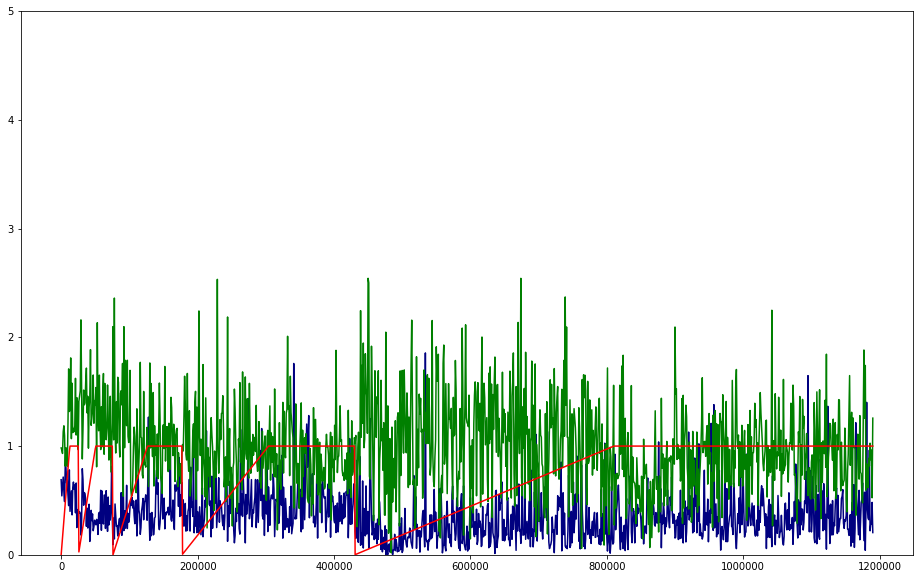

In [12]:
every = 1000
count = None

plt.figure(figsize=(16, 10))
plt.ylim(0, 5)
plt.plot([l['iter'] for l in Log[:count:every]], [l['Loss_D_real'] for l in Log[:count:every]], color='navy')
plt.plot([l['iter'] for l in Log[:count:every]], [l['Loss_G'] for l in Log[:count:every]], color='green')
plt.plot([l['iter'] for l in Log[:count:every]], [l['alpha'] for l in Log[:count:every]], color='red')
plt.show()

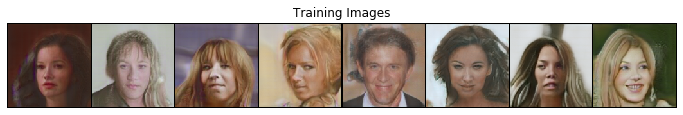

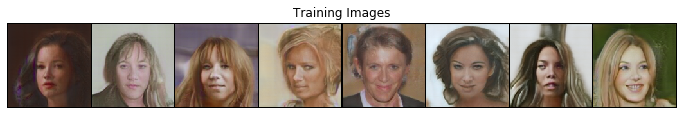

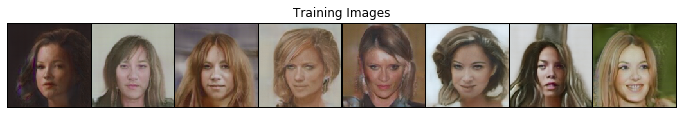

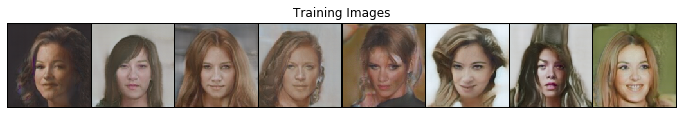

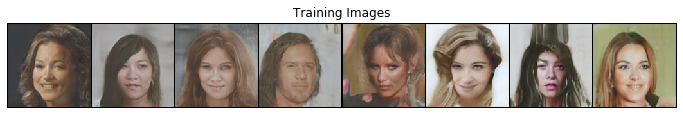

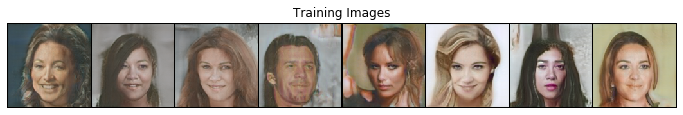

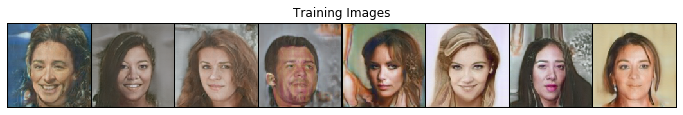

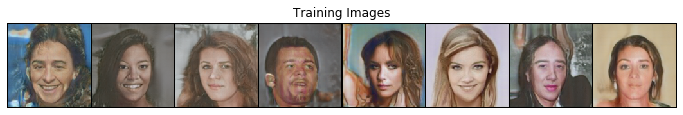

In [44]:
bs = 8
fixed_z_1 = th.randn(bs, dim_latent, device=device)
fixed_z_1[fixed_z_1 > 1.0] *= 0.5

fixed_z_2 = th.randn(bs, dim_latent, device=device)
fixed_z_2[fixed_z_2 > 1.0] *= 0.5

fixed_noise_1 = MakeNoiseList(batch_size=bs, depth=depth)
fixed_noise_2 = MakeNoiseList(batch_size=bs, depth=depth)

for alpha in np.linspace(0.0, 1.0, 8):
    with th.no_grad():
        z = fixed_z_1 * alpha + fixed_z_2 * (1.0 - alpha)
        noise = fixed_noise_1

        fake = GEN(z=z, depth=depth, noise=noise).detach().cpu()
        
        img = vutils.make_grid(
            fake,
            nrow=8,
            padding=2,
            normalize=True
        )

        plt.figure(figsize=(12,3))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(
            np.transpose(
                img,
                (1,2,0)
            )
        )

torch.Size([24, 3, 128, 128])


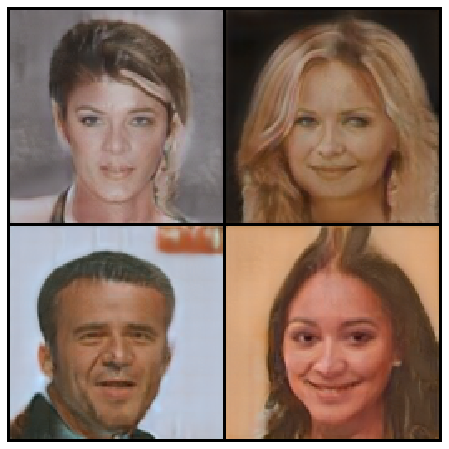

In [40]:
bs = 24
fixed_z_1 = th.randn(bs, dim_latent, device=device)
fixed_z_1[fixed_z_1 > 1.0] *= 0.5

fixed_noise_1 = MakeNoiseList(batch_size=bs, depth=depth)

with th.no_grad():
    z = fixed_z_1
    noise = fixed_noise_1

    fake = GEN(z=z, depth=depth, noise=noise).detach().cpu()
    fake_output = DIS(fake.detach(), depth, alpha=1.0).view(-1)
    scores = F.softplus(fake_output).detach().cpu().numpy()
    #print(scores)
    np.argsort(scores)

    print(fake[np.argsort(scores), ...].shape)

    img = vutils.make_grid(
        fake[np.argsort(scores), ...][-4:, ...],
        nrow=2,
        padding=2,
        normalize=True
    )

    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(
        np.transpose(
            img,
            (1,2,0)
        )
    )

In [24]:
th.save({
    'generator'    : GEN.state_dict(),
    'discriminator': DIS.state_dict(),
    'g_optim'      : optimizerG.state_dict(),
    'd_optim'      : optimizerD.state_dict(),
}, 'StyleGan_trained_128_2.pth')

/home/leshchev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


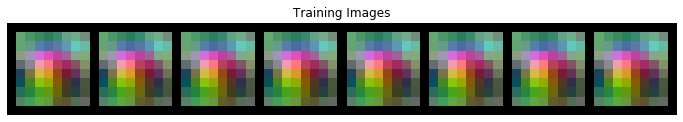

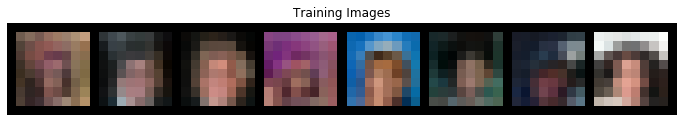

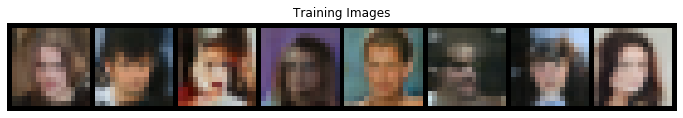

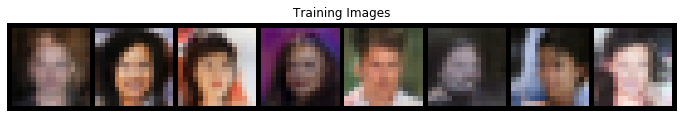

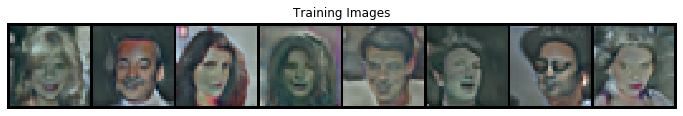

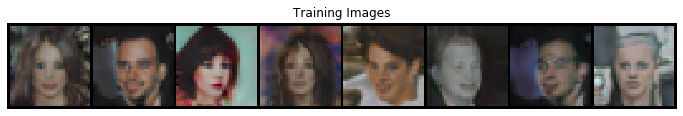

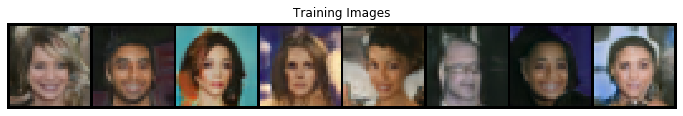

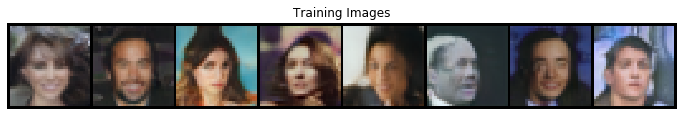

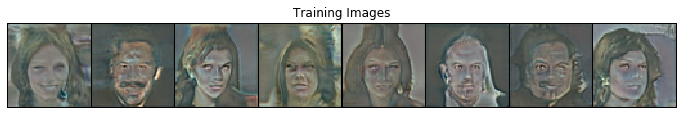

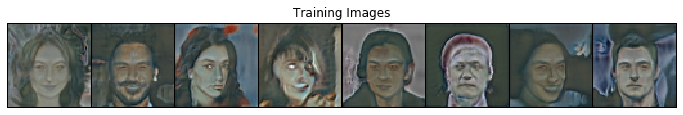

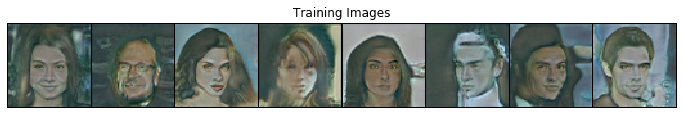

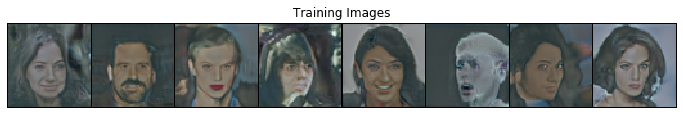

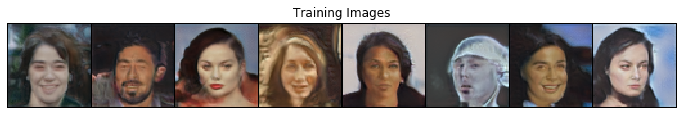

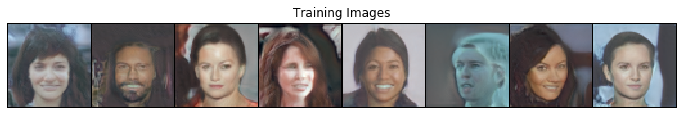

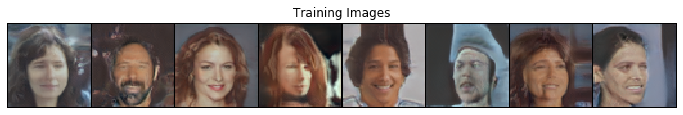

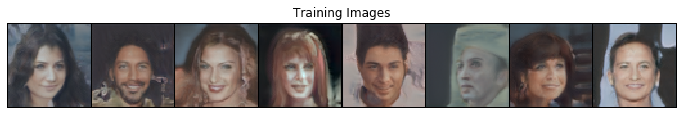

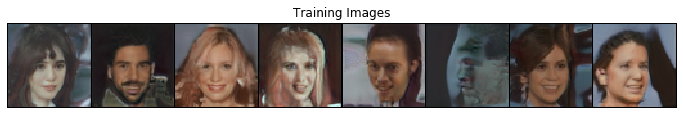

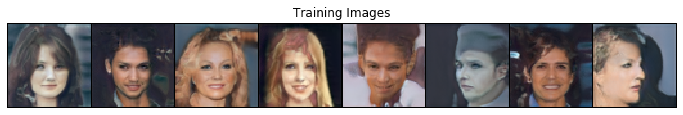

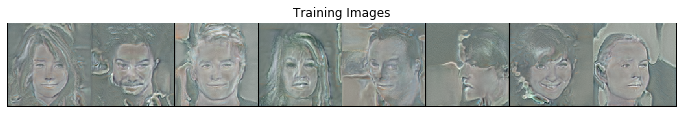

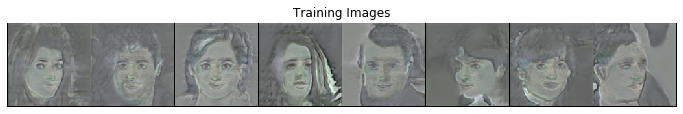

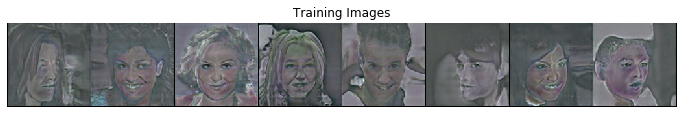

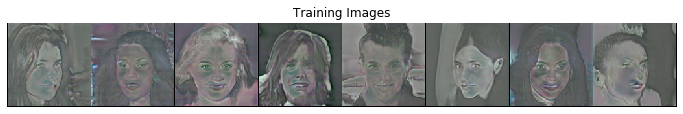

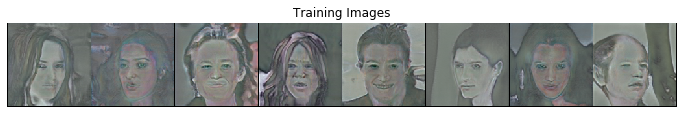

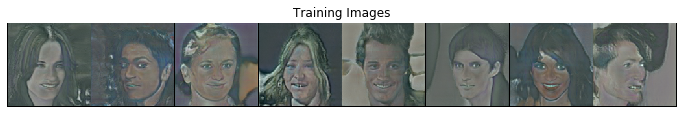

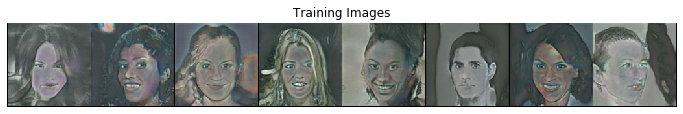

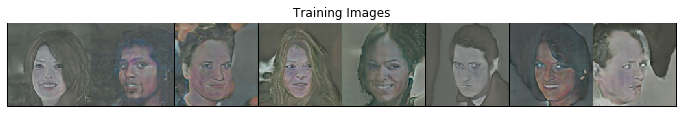

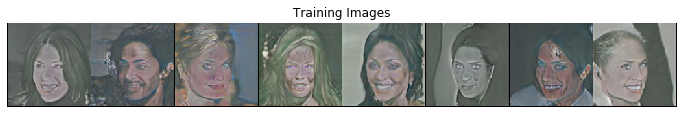

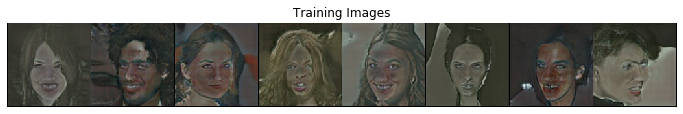

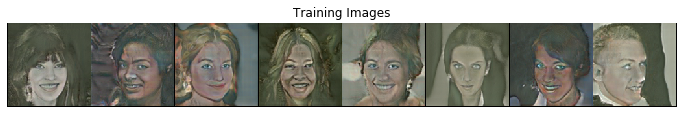

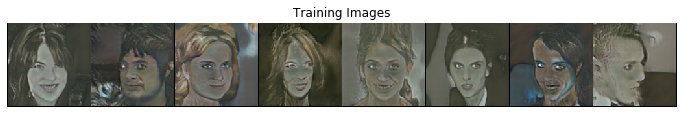

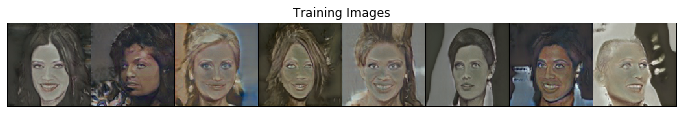

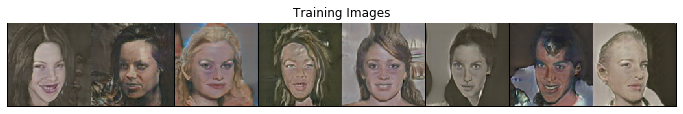

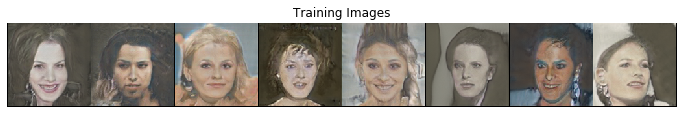

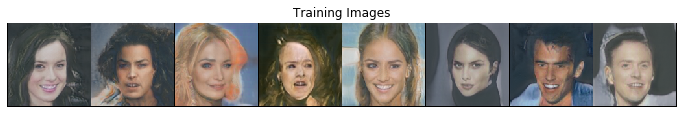

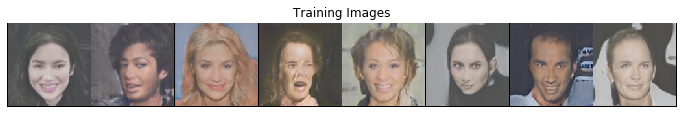

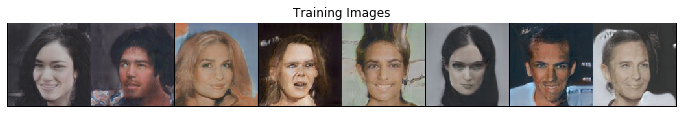

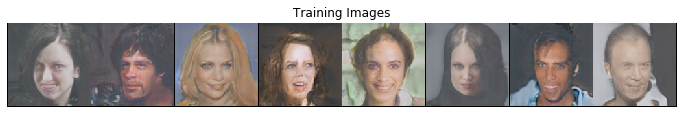

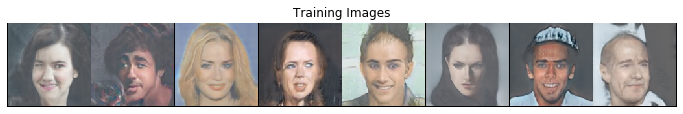

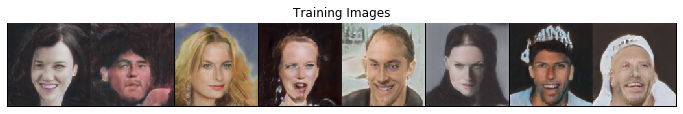

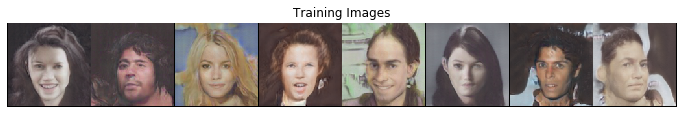

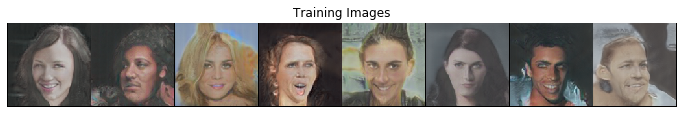

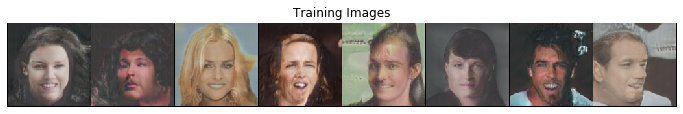

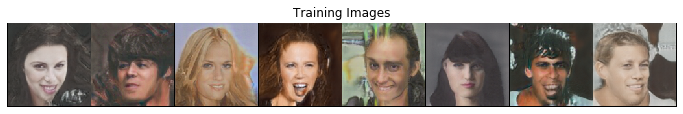

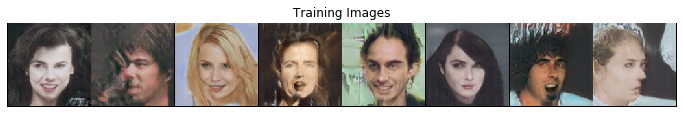

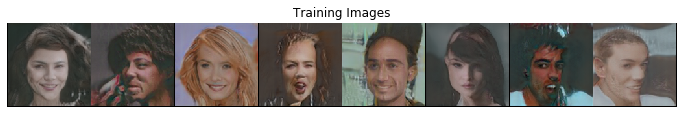

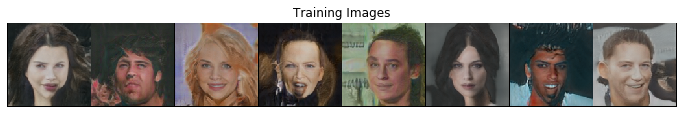

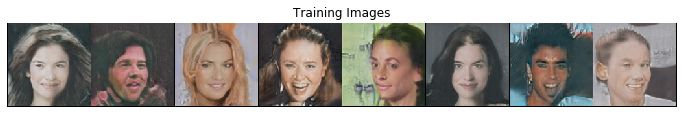

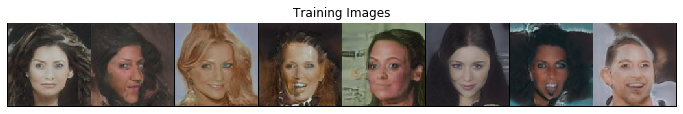

In [26]:
for i in range(0, len(img_list), 50):

    plt.figure(figsize=(12,8))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(
        np.transpose(
            vutils.make_grid(img_list[i][:8, ...], nrow=8, padding=1, normalize=True),
            (1,2,0)
        )
    )